## Hyperparameter tuning decision tree using optuna

https://optuna.readthedocs.io/en/stable/tutorial/index.html


In [1]:
#importing packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#supress warnings
import warnings
warnings.filterwarnings('ignore')

DATA:     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
FEATURE NAMES:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
TARGET NAMES:  ['setosa' 'versicolor' 'virginica']
ACCURACY:  1.0


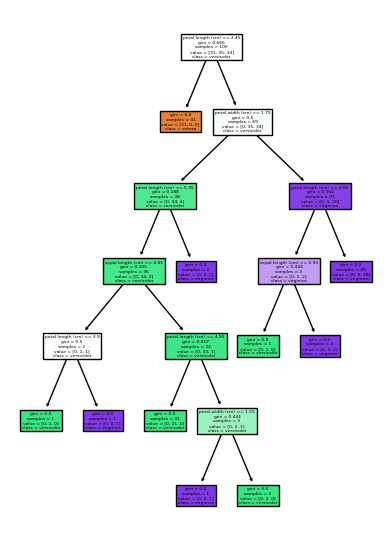

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
data = pd.DataFrame(data= np.c_[iris['data'], iris['target']], columns= iris['feature_names'] + ['target'])

print("DATA: ", data.head())

target_names = iris.target_names
feature_names = iris.feature_names

print("FEATURE NAMES: ", feature_names)
print("TARGET NAMES: ", target_names)

from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.333, random_state=42, shuffle=True)

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(train[feature_names],train['target'])

#checking accuracy
from sklearn.metrics import accuracy_score
pred = model.predict(test[feature_names])
print("ACCURACY: ", accuracy_score(test['target'], pred))

#plotting the tree
from sklearn.tree import plot_tree
plt.figure(figsize=(4.8,6.8))
plot_tree(model, feature_names=feature_names, class_names=target_names, filled=True)
plt.show()
plt.close()

In [3]:
#installing optuna library using pip
!pip install optuna

#After installing Optuna, we can import the library into our Python session.
import optuna


[notice] A new release of pip is available: 23.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## Tuning a Decision Tree Model using Optuna

Reference: https://drbeane.github.io/python_ml/pages/autosearch.html

To use Optuna to perform hyperparameter tuning for a specific model type, a study must be created. 

A study in Optuna refers to a single optimization problem. 

Each Optuna study consists of multiple trials. 

A trial in optuna is a single execution of a function that returns a value meanted to be minimized or maximized. 

In the context of hyperparameter tuning, a trial consists of selecting hyperparameter values for a model and then scoring the resulting model in some way, typically by using cross-validation.

### An outline of the steps involved in creating a study is as follows:

    1. Create an objective function representing a trial. 
        a. Within the objective function, new hyperparameter values should be selected. 
        b. A model object should be created using the new hyperparameter values. 
        c. The model should be scored using cross-validation. 
        d. The cross-validation score should be returned by the objective function.

    2. Create a study object, indiciate if the objective should be minimized or maximized.

    3. Pass the objective function to the study object’s optimize() method, specifying the number of trials to perform. This will start the study.

The objective function should accept a single trial object as a parameter. 

Arguments for this parameter are supplied to the objective function when the `optimize()` function is called.

The hyperparameter values are generated by using `suggest_float()`, `suggest_int()`, and `suggest_categorical()` methods of the trial object.

The paramaters passed to these methods will define the parameter search space for the study. 

Optuna makes use of Bayesian optimization to strategically explore the search space for an optimal set of parameter values. 

It does this by employing an explore/exploit strategy in which new values are selected at random for each new trial, but values that have previously shown good performance will be selected more frequently.


In [4]:
#defining objective function

def objective_function(trial):

    #defining hyperparameters to be tuned
    max_depth = trial.suggest_int('max_depth', 1, 32)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    ccp_alpha = trial.suggest_uniform('ccp_alpha', 0.0, 1.0)
    random_state = trial.suggest_int('random_state', 1, 100)

    #defining model
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        criterion=criterion,
        splitter=splitter,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        ccp_alpha=ccp_alpha,
        random_state=random_state
    )

    #fitting model
    model.fit(train[feature_names], train['target'])

    #returning test accuracy
    return accuracy_score(test['target'], model.predict(test[feature_names]))

In [5]:
dtree_study = optuna.create_study(direction='maximize', storage='sqlite:///dtree.db', study_name='dtree', load_if_exists=False)
dtree_study.optimize(objective_function, n_trials=100)

[I 2023-09-09 10:15:34,354] A new study created in RDB with name: dtree
[I 2023-09-09 10:15:34,732] Trial 0 finished with value: 0.3 and parameters: {'max_depth': 2, 'criterion': 'gini', 'splitter': 'random', 'min_samples_split': 17, 'min_samples_leaf': 32, 'max_features': 'log2', 'ccp_alpha': 0.12069650410746202, 'random_state': 25}. Best is trial 0 with value: 0.3.
[I 2023-09-09 10:15:35,193] Trial 1 finished with value: 0.3 and parameters: {'max_depth': 24, 'criterion': 'gini', 'splitter': 'random', 'min_samples_split': 6, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'ccp_alpha': 0.9197946240078229, 'random_state': 83}. Best is trial 0 with value: 0.3.
[I 2023-09-09 10:15:35,478] Trial 2 finished with value: 0.3 and parameters: {'max_depth': 1, 'criterion': 'gini', 'splitter': 'random', 'min_samples_split': 29, 'min_samples_leaf': 32, 'max_features': 'sqrt', 'ccp_alpha': 0.9574223620660391, 'random_state': 42}. Best is trial 0 with value: 0.3.
[I 2023-09-09 10:15:35,866] Trial 3 

In [6]:
#best hyperparameters
dtree_study.best_params

{'max_depth': 23,
 'criterion': 'entropy',
 'splitter': 'best',
 'min_samples_split': 32,
 'min_samples_leaf': 21,
 'max_features': None,
 'ccp_alpha': 0.11793667480096082,
 'random_state': 91}

In [7]:
#best score
dtree_study.best_value

0.98

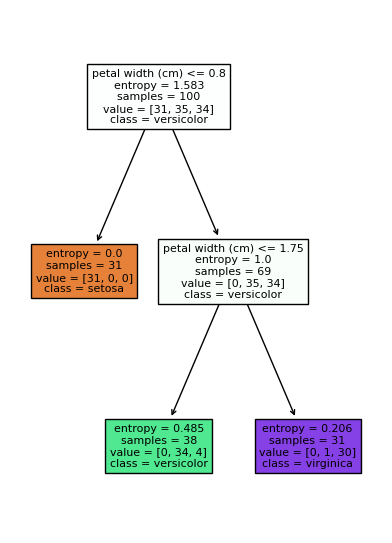

ACCURACY TEST:  0.98
ACCURACY TRAIN:  0.95


In [8]:
#plot the best tree

best_model = DecisionTreeClassifier(
    max_depth=dtree_study.best_params['max_depth'],
    criterion=dtree_study.best_params['criterion'],
    splitter=dtree_study.best_params['splitter'],
    min_samples_split=dtree_study.best_params['min_samples_split'],
    min_samples_leaf=dtree_study.best_params['min_samples_leaf'],
    max_features=dtree_study.best_params['max_features'],
    random_state=dtree_study.best_params['random_state']
)

best_model.fit(train[feature_names], train['target'])

plt.figure(figsize=(4.8,6.8))
plot_tree(best_model, feature_names=feature_names, class_names=target_names, filled=True)
plt.show()
plt.close()

#print the accuracy of the best model
print("ACCURACY TEST: ", accuracy_score(test['target'], best_model.predict(test[feature_names])))
print("ACCURACY TRAIN: ", accuracy_score(train['target'], best_model.predict(train[feature_names])))

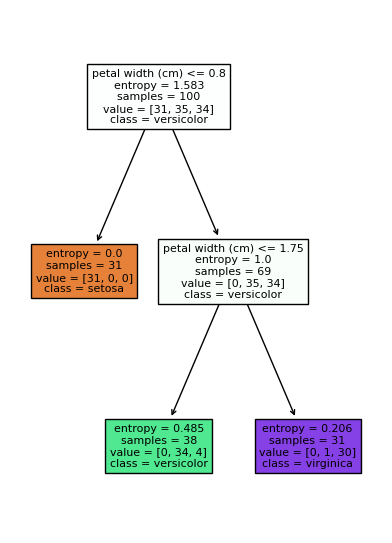

ACCURACY TEST:  0.98
ACCURACY TRAIN:  0.95


In [9]:
#plot the best tree

best_model = DecisionTreeClassifier(
    max_depth=dtree_study.best_params['max_depth'],
    criterion=dtree_study.best_params['criterion'],
    splitter=dtree_study.best_params['splitter'],
    min_samples_split=dtree_study.best_params['min_samples_split'],
    min_samples_leaf=dtree_study.best_params['min_samples_leaf'],
    max_features=dtree_study.best_params['max_features'],
    ccp_alpha=dtree_study.best_params['ccp_alpha'],
    random_state=dtree_study.best_params['random_state']
)

best_model.fit(train[feature_names], train['target'])

plt.figure(figsize=(4.8,6.8))
plot_tree(best_model, feature_names=feature_names, class_names=target_names, filled=True)
plt.show()

#print the accuracy of the best model
print("ACCURACY TEST: ", accuracy_score(test['target'], best_model.predict(test[feature_names])))
print("ACCURACY TRAIN: ", accuracy_score(train['target'], best_model.predict(train[feature_names])))

## OPTUNA VISUALIZATIONS

https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#sphx-glr-download-tutorial-10-key-features-005-visualization-py


In [10]:
#plot contour
plt.figure(figsize=(6.8,6.8))
optuna.visualization.plot_contour(dtree_study, params=['max_depth', 'min_samples_split'])

<Figure size 680x680 with 0 Axes>

In [11]:
#plot optimization history
plt.figure(figsize=(6.8,6.8))
optuna.visualization.plot_optimization_history(dtree_study)

<Figure size 680x680 with 0 Axes>

In [12]:
!pip install optuna-dashboard

!optuna-dashboard sqlite:///dtree.db


[notice] A new release of pip is available: 23.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Listening on http://127.0.0.1:8080/
Hit Ctrl-C to quit.

127.0.0.1 - - [09/Sep/2023 10:18:28] "GET / HTTP/1.1" 302 0
127.0.0.1 - - [09/Sep/2023 10:18:28] "GET /dashboard HTTP/1.1" 304 0
127.0.0.1 - - [09/Sep/2023 10:18:28] "GET /static/bundle.js HTTP/1.1" 200 2200065
/home/anjalip/anaconda3/envs/universe/lib/python3.8/site-packages/optuna/study/_study_summary.py:115: FutureWarning: `system_attrs` has been deprecated in v3.1.0. The removal of this feature is currently scheduled for v5.0.0, but this schedule is subject to change. See https://github.com/optuna/optuna/releases/tag/v3.1.0.
  warnings.warn(
127.0.0.1 - - [09/Sep/2023 10:18:29] "GET /api/studies HTTP/1.1" 200 127
127.0.0.1 - - [09/Sep/2023 10:18:34] "GET /api/meta HTTP/1.1" 200 32
127.0.0.1 - - [09/Sep/2023 10:18:34] "GET /api/studies/1?after=0 HTTP/1.1" 200 244993
127.0.0.1 - - [09/Sep/2023 10:18:34] "GET /api/studi